#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## 1. Подготовка данных

Установим и импортируем библиотеки

In [1]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# Отключим оповещения
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

# Зададим константы, которые будем использовать во всём проекте.
RANDOM_STATE = 42

### 1.1. Загрузим данные из файла в переменную data

Данные загружены

### 1.2. Посмотрим основную информацию о датафреймах, воспользуемся функцией

In [4]:
def show_main_info (df):
    # print(df.name)
    display(df.head())
    display(df.describe(include = 'all'))
    # display(df.describe())
    display(df.info())
    # print('\nДубликатов:', df.duplicated().sum())
    print('\nПропущенные значения:')
    # display(100*df.isna().sum().sort_values(ascending=False)/df.shape[0])
    display(df.isna().sum().sort_values(ascending=False))
    
    # display(df.corr())
    # PhiK Correlation
    
    # phik_overview = df.phik_matrix();
    # display(phik_overview.round(2))
    
    # plot_correlation_matrix(phik_overview.values, 
    #                         x_labels=phik_overview.columns, 
    #                         y_labels=phik_overview.index, 
    #                         vmin=0, vmax=1, color_map="Blues", 
    #                         title=r"correlation $\phi_K$", 
    #                         fontsize_factor=1, 
    #                         figsize=(8, 6));
    # plt.tight_layout();
    if int(df.shape[1]/4) <1:
        size =1
    else:
        size = int(df.shape[1]/4)
    df.hist(figsize=(15, size*4), bins=50, layout=(size,4));
    
    print('\n\n---------------------------------------------------------------------\n')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None


Пропущенные значения:


num_orders    0
dtype: int64



---------------------------------------------------------------------



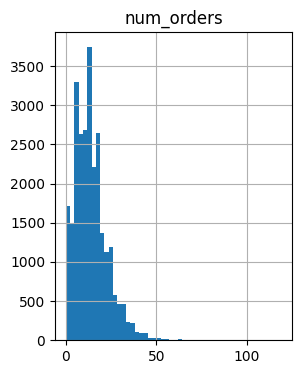

In [5]:
show_main_info(data)

В выборке представлены данные за период с **2018-03-01 00:00:00** по **2018-08-31 23:50:00**

Проверим, что данные отсортированы в хронологическом порядке.

In [6]:
data.index.is_monotonic

True

data.sort_index(inplace=True)

Проверим индекс на уникальность.

In [7]:
data.index.is_unique

True

### 1.3. Выполним ресемплирование интервалом в час.

In [8]:
data = data.resample('H').sum()
data_re = data.copy()

In [9]:
data_re.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Построим график временного ряда.

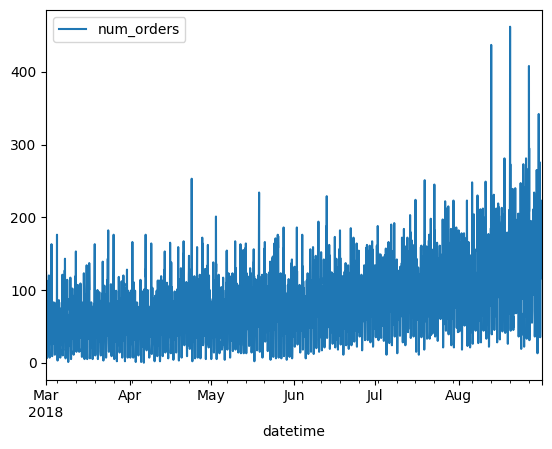

In [10]:
data.plot();

Имеется тенденция к увеличению количества заказов.

## Вывод

Данные загружены.

Проверен хронологический порядок.

Выполнено ресемплирование с интервалом в 1 час.

## 2. Анализ

Разложим временной ряд на тренд и сезонную компоненту. Построим их графики.

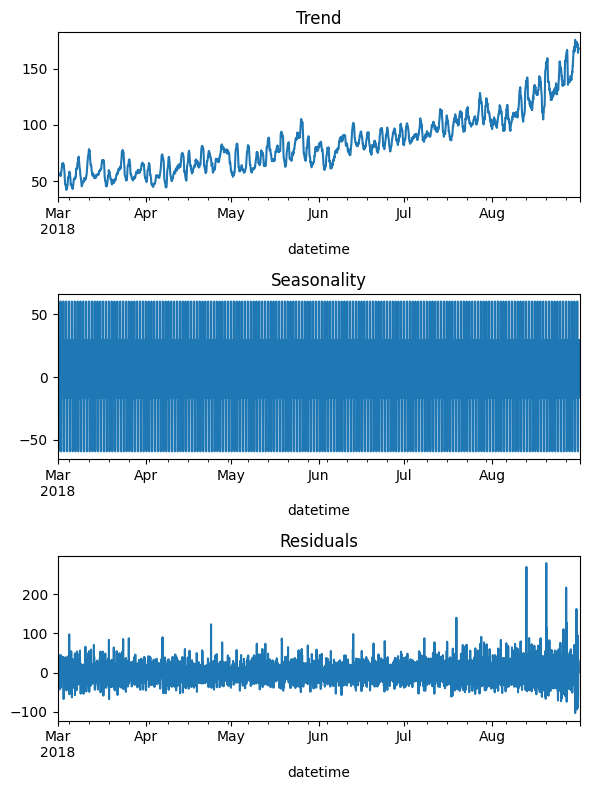

In [11]:
decomposed = seasonal_decompose(data)
# Функция seasonal_decompose() принимает временной ряд, а возвращает объект структуры DecomposeResult (англ. «результат разделения»). В нём есть нужные атрибуты:
# decomposed.trend — тренд;
# decomposed.seasonal — сезонная составляющая;
# decomposed.resid — остаток декомпозиции.

plt.figure(figsize=(6, 8))

plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

График тренда постепенно возрастает, что подтверждает увеличение количества заказов.

График сезонности посмотрим в ином масштабе.

Построим график сезонной составляющей за последние 3 дня августа 2018 года.

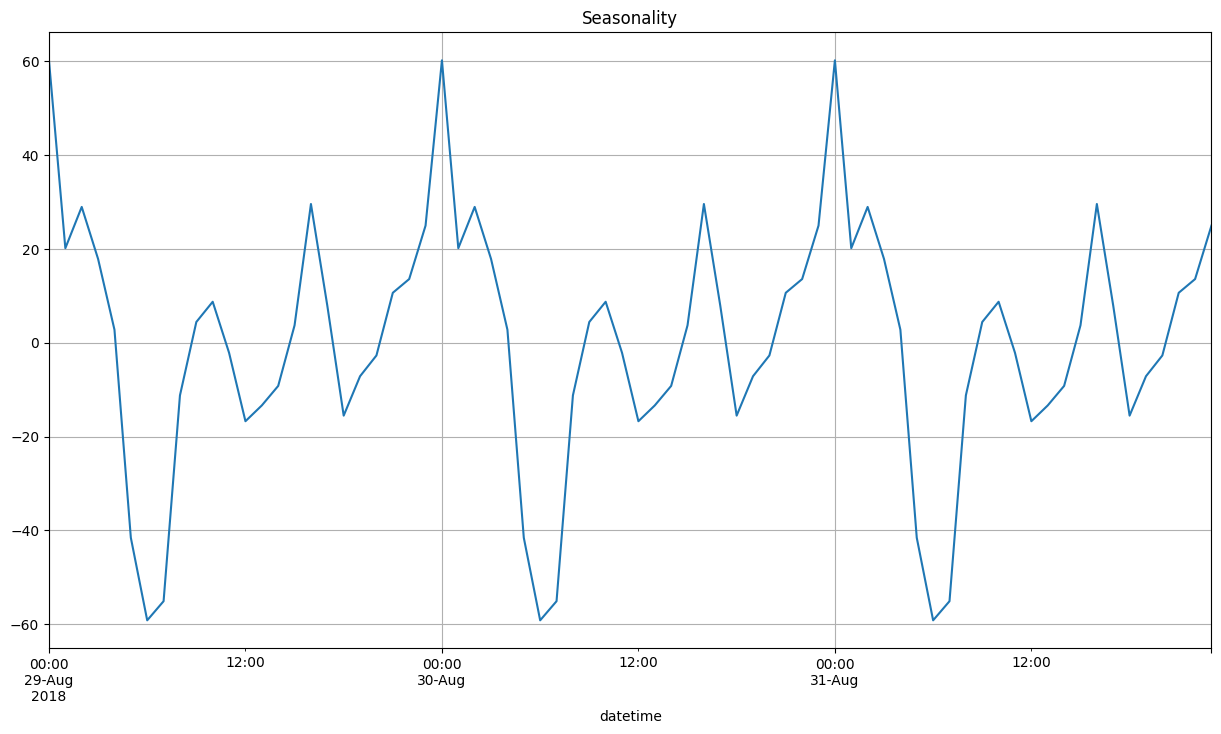

In [12]:
plt.figure(figsize=(15, 8))
decomposed.seasonal['2018-08-29': '2018-08-31'].plot(ax=plt.gca(), grid=True)
plt.title('Seasonality');

Сезонность на графике ежедневная.

С 6 утра начинается рост количества заказов, достигая максимального пика к полуночи и далее идёт спад.

Создадим признаки для горизонта прогнозирования в один шаг.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    # 1. Календарные признаки 
    # data['year'] = data.index.year
    # data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    # 2. «Отстающие значения»
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data.num_orders.shift(lag)

    # 3. Скользящее среднее
    # Текущее значение ряда для расчёта скользящего среднего применять нельзя.
    # Чтобы не учитывать текущее значение, вызовите метод shift():
    data['rolling_mean'] = data.num_orders.shift().rolling(rolling_mean_size).mean()
    # 4. Скользящее стандартное отклонение
    data['rolling_std'] = data.num_orders.shift().rolling(rolling_mean_size).std()
    
    return data
    
    # 5. Разности временного ряда
    # data['diff'] = data.num_orders.diff()
    # data['diff_2'] = data.num_orders.diff(periods = 2) # periods – кол-во шагов между датами

In [14]:
# make_features(data, 6, 3)
make_features(data, 23, 11)
display(data.head(10))

,num_orders,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,1,5,3,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,1,6,3,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,1,7,3,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,1,8,3,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


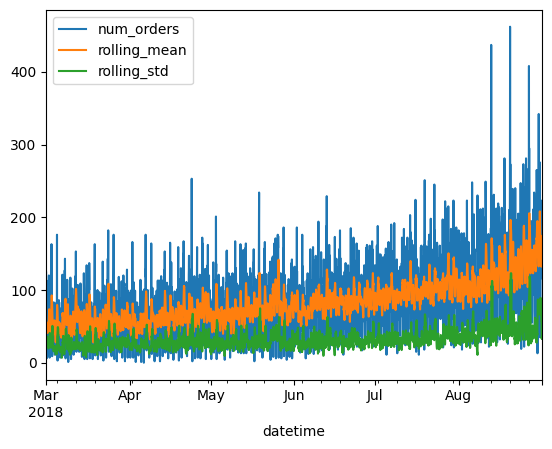

In [15]:
data.loc['2018-03-01':'2018-08-31',['num_orders', 'rolling_mean', 'rolling_std']].plot();

## Вывод

Выяснили, что в данных прослеживается общая тенденция увеличения количества заказов.

Выявили сезонную составляющую, которая оказалась равна 1 дню.

Больше всего заказов приходится на вечернее и ночное время.

## 3. Обучение

### 3.1. Разобъём датасет на выборки

Сделаем тестовую выборку размером 10% от исходных данных.

In [16]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 23:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


В выборках выделим признаки и целевой признак.

In [17]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3951, 28)
(3951,)
(442, 28)
(442,)


Выборки готовы.

### 3.2. RandomForestRegressor

In [19]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [20]:
tscv = TimeSeriesSplit()

scaler = StandardScaler()

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(scaler, model_rf)


param_grid_rf = {
    'randomforestregressor__n_estimators': range(10, 18, 2),
    'randomforestregressor__max_depth': range(3, 11, 2),
    'randomforestregressor__max_features': range(8,19,2)#,
    #'randomforestregressor__min_samples_split': (2, 3),
    #'randomforestregressor__min_samples_leaf': (1, 2, 3)
}

# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает на много быстрее
gs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_distributions=param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    cv=tscv,
    random_state=RANDOM_STATE
)

gs_rf.fit(X_train_rf, y_train)

gs_rf_best_score = gs_rf.best_score_ * -1
gs_rf_best_params = gs_rf.best_params_
print(f'best_RMSE: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_RMSE: 26.6115542746253
best_params: {'randomforestregressor__n_estimators': 14, 'randomforestregressor__max_features': 18, 'randomforestregressor__max_depth': 9}


### 3.3. LinearRegression

In [21]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [22]:
tscv = TimeSeriesSplit()

scaler = StandardScaler()

model_lr = LinearRegression()

pipline_lr = make_pipeline(scaler, model_lr)

param_grid_lr = {'linearregression__fit_intercept':[True, False]}


# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает на много быстрее
gs_lr = RandomizedSearchCV(
    pipline_lr,
    param_distributions=param_grid_lr,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    cv=tscv,
    random_state=RANDOM_STATE
)

gs_lr.fit(X_train_lr, y_train)

gs_lr_best_score = gs_lr.best_score_ * -1
gs_lr_best_params = gs_lr.best_params_
print(f'best_RMSE: {gs_lr_best_score}')
print(f'best_params: {gs_lr_best_params}')

best_RMSE: 30.006381924512084
best_params: {'linearregression__fit_intercept': True}


### 3.4. LightGBM

In [23]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

In [24]:
tscv = TimeSeriesSplit()

scaler = StandardScaler()

model_lgbm = LGBMRegressor()

pipline_lgbm = make_pipeline(scaler, model_lgbm)

param_grid_lgbm = {'lgbmregressor__num_leaves':[31, 100, 200], 
                   'lgbmregressor__learning_rate':[x/10 for x in range(1, 6)]}


# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает на много быстрее
gs_lgbm = RandomizedSearchCV(
    pipline_lgbm,
    param_distributions=param_grid_lgbm,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    cv=tscv,
    random_state=RANDOM_STATE
)

gs_lgbm.fit(X_train_lgbm, y_train)
# , eval_metric='rmse', categorical_feature=cat_features_ohe+cat_features_oe

gs_lgbm_best_score = gs_lgbm.best_score_ * -1
gs_lgbm_best_params = gs_lgbm.best_params_
print(f'best_RMSE: {gs_lgbm_best_score}')
print(f'best_params: {gs_lgbm_best_params}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4936
[LightGBM] [Info] Number of data points in the train set: 3951, number of used features: 28
[LightGBM] [Info] Start training from score 78.415844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

### 3.5. CatBoost

In [25]:
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

In [26]:
tscv = TimeSeriesSplit()

scaler = StandardScaler()

model_cb = CatBoostRegressor()

pipline_cb = make_pipeline(scaler, model_cb)

param_grid_cb = {'catboostregressor__learning_rate':[x/10 for x in range(1, 6)],
                'catboostregressor__loss_function':['RMSE'],
                 'catboostregressor__iterations': [223],
                'catboostregressor__verbose':[False]}

# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает на много быстрее
gs_cb = RandomizedSearchCV(
    pipline_cb,
    param_distributions=param_grid_cb,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    cv=tscv,
    random_state=RANDOM_STATE
)

gs_cb.fit(X_train_cb, y_train)
# , eval_metric='rmse', categorical_feature=cat_features_ohe+cat_features_oe

gs_cb_best_score = gs_cb.best_score_ * -1
gs_cb_best_params = gs_cb.best_params_
print(f'best_RMSE: {gs_cb_best_score}')
print(f'best_params: {gs_cb_best_params}')

best_RMSE: 26.805546212022826
best_params: {'catboostregressor__verbose': False, 'catboostregressor__loss_function': 'RMSE', 'catboostregressor__learning_rate': 0.5, 'catboostregressor__iterations': 223}


### 3.6. Проверка адекватности

Спрогнозировать временные ряды без обучения можно двумя способами:
- Все значения тестовой выборки предсказываются одним и тем же числом (константой). Для метрики MAE — это медиана.
- Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1). Этот способ не зависит от метрики.

In [27]:
print('Среднее количество заказов:', test.num_orders.mean())

pred_median = np.ones(test.shape) * train.num_orders.median()
print('RMSE:', mean_squared_error(test, pred_median, squared=False))

Среднее количество заказов: 139.55656108597285
RMSE: 81.95092682116172


In [28]:
print('Среднее количество заказов:', test.num_orders.mean())
last = train.num_orders.iloc[-1]
pred_previous =  np.ones(test.shape) * test.shift(fill_value=last)
print('RMSE:', mean_squared_error(test, pred_previous, squared=False))

Среднее количество заказов: 139.55656108597285
RMSE: 50.41263725507808


## Вывод

Все модели прошли проверку адекватности.

Наилучшие результаты показала модель CatBoost.

## 4. Тестирование

Проверим лучшую модель на тестовой выборке

In [29]:
X_train_final = X_train.copy()
X_test_final = X_test.copy()

In [30]:
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

model = CatBoostRegressor(loss_function='RMSE', iterations=223, learning_rate=.1, random_state=RANDOM_STATE)
model.fit(X_train_final, y_train, verbose=False)
best_score = model.best_score_
y_pred = model.predict(X_test_final)
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
# print(f'RMSE: {best_score}')

RMSE: 42.01554915993706


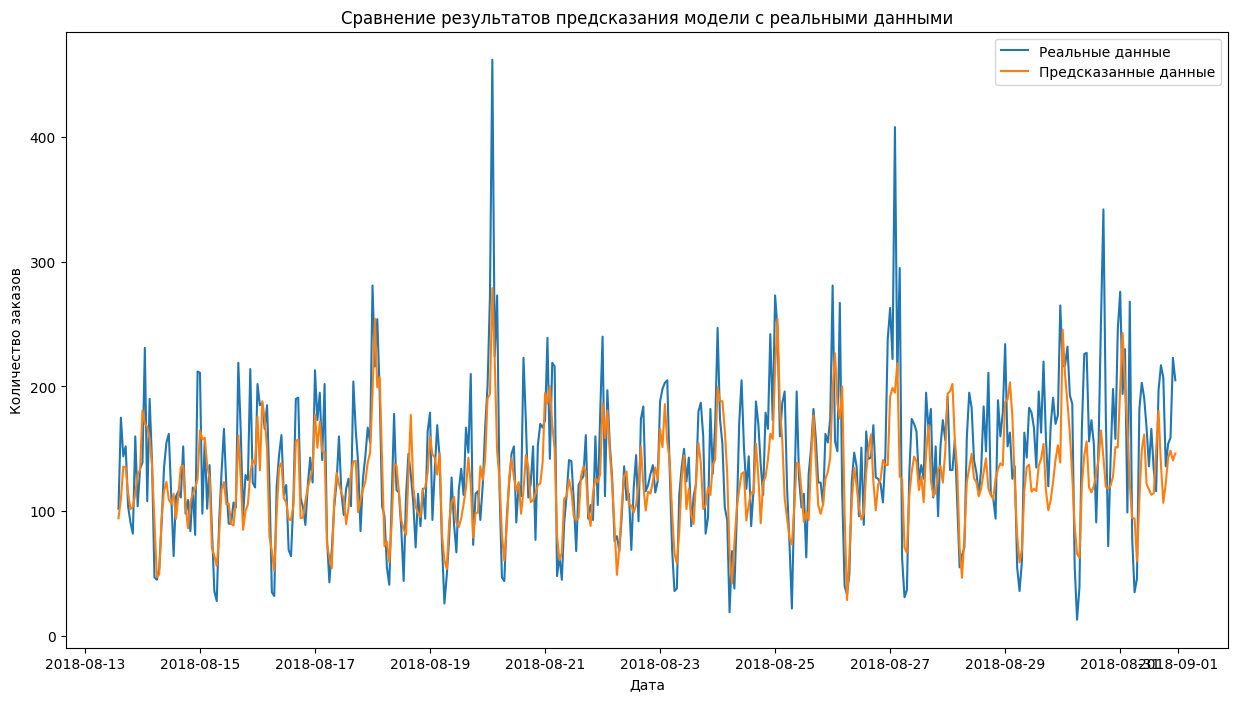

In [31]:
plt.figure(figsize=(15, 8))
plt.plot(X_test.index, y_test, label='Реальные данные')
plt.plot(X_test.index, y_pred, label='Предсказанные данные')
plt.legend()
plt.title('Сравнение результатов предсказания модели с реальными данными')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

## Вывод

Выбранная нами модель подтвердила свою эффективность на тестовой выборке и соответствует условиям задачи.